TFG

1.   Importación de datos
2.   Preprocesamiento de los datos
3.   Modelo de clasificacion (transfer learning y modelo simple)
4.   Modelo de segmentacion con los resultados del modelo anterior
5.   Representacion de los resultados


# Librerias

In [1]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00


In [22]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Importación de los datos

In [3]:
nombre_archivo_zip = 'archive.zip'
ruta_zip = f'/content/{nombre_archivo_zip}'

# Ruta donde vamos a descomprimir
ruta_extraccion = '/content/dataset_lgg'

# Comprobamos si has subido el archivo
if not os.path.exists(ruta_zip):
    print(f"❌ ERROR: No encuentro el archivo '{nombre_archivo_zip}' en la carpeta de archivos.")
    print("👉 Por favor, sube el .zip usando el icono de la carpeta a la izquierda antes de ejecutar esto.")
else:
    # Descomprimir
    if not os.path.exists(ruta_extraccion):
        print("📂 Descomprimiendo archivo local...")
        with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
            zip_ref.extractall(ruta_extraccion)
        print("✅ ¡Descompresión completada!")
    else:
        print("✅ El archivo ya estaba descomprimido.")

📂 Descomprimiendo archivo local...
✅ ¡Descompresión completada!


# 2. Preprocesamiento de los datos

🔍 Escaneando imágenes en: /content/dataset_lgg/kaggle_3m
🧹 Filtrando imágenes vacías (sin tumor)...
Total imágenes: 3929
Imágenes CON tumor (Dataset final): 1373

👁️ Visualizando muestras aleatorias...


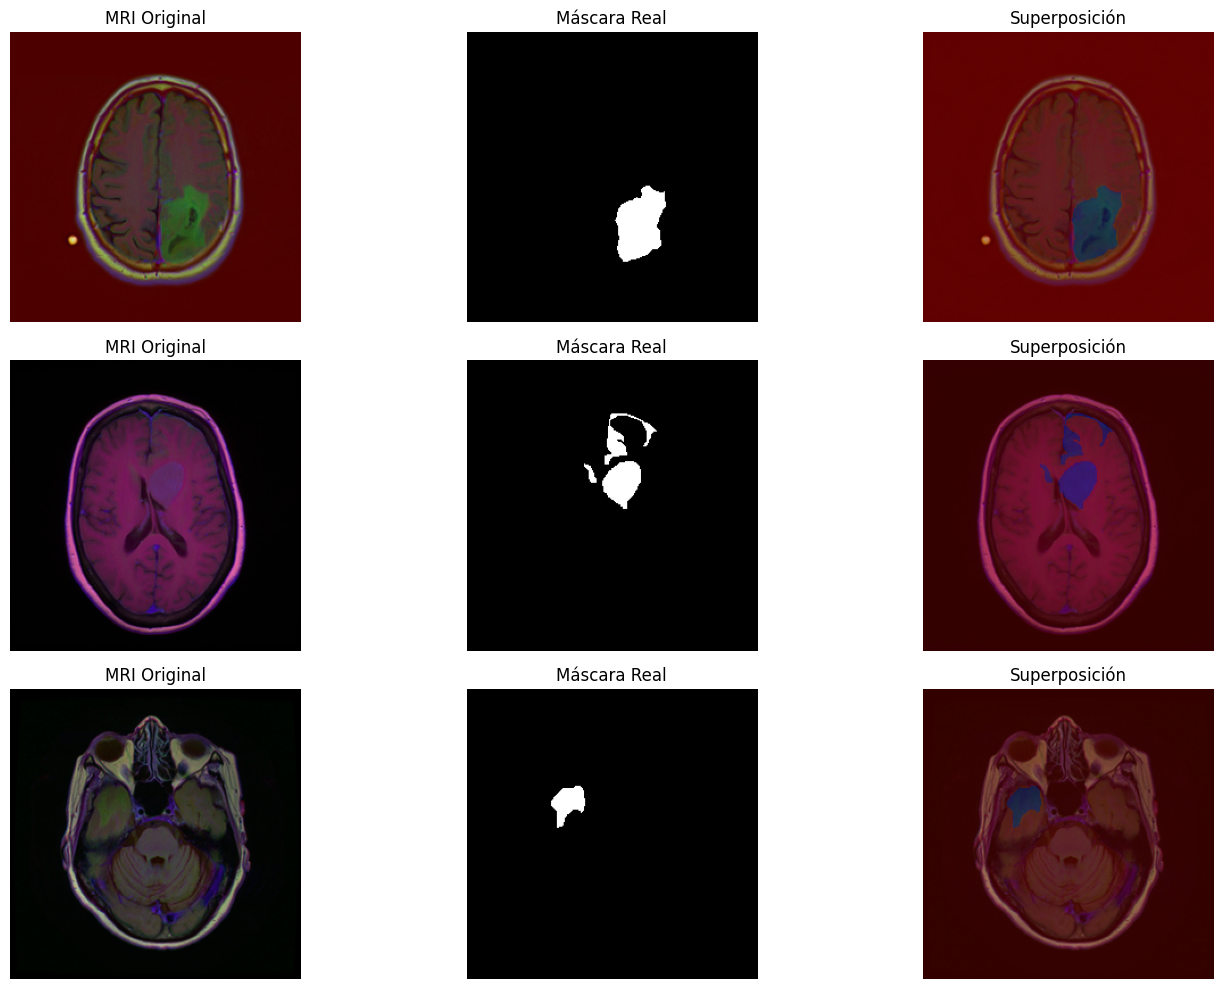

In [4]:
possible_dir = os.path.join(ruta_extraccion, 'kaggle_3m')
data_dir = possible_dir if os.path.exists(possible_dir) else ruta_extraccion

image_paths = []
mask_paths = []

print(f"🔍 Escaneando imágenes en: {data_dir}")

for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if 'mask' in filename:
            mask_path = os.path.join(dirname, filename)
            image_filename = filename.replace('_mask', '')
            image_path = os.path.join(dirname, image_filename)

            if os.path.exists(image_path):
                mask_paths.append(mask_path)
                image_paths.append(image_path)

# DataFrame inicial
df = pd.DataFrame({'image_path': image_paths, 'mask_path': mask_paths})

# Función para detectar si la máscara tiene tumor (píxeles blancos)
def tiene_tumor(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return np.max(mask) > 0

# Filtrar datos
print("🧹 Filtrando imágenes vacías (sin tumor)...")
if len(df) > 0:
    df['has_tumor'] = df['mask_path'].apply(tiene_tumor)
    df_segmentacion = df[df['has_tumor'] == True].reset_index(drop=True)

    print(f"Total imágenes: {len(df)}")
    print(f"Imágenes CON tumor (Dataset final): {len(df_segmentacion)}")

    # ==========================================
    # 3. VISUALIZACIÓN
    # ==========================================
    print("\n👁️ Visualizando muestras aleatorias...")

    # Elegir 3 índices al azar
    indices = np.random.choice(len(df_segmentacion), 3, replace=False)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = df_segmentacion.iloc[idx]

        # Cargar
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)

        # Overlay
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

        # Plot
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("MRI Original")
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Máscara Real")
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(overlay)
        plt.title("Superposición")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("❌ No se encontraron imágenes. Revisa la estructura del ZIP.")

# 3. Modelos de segmentación

## VGG

In [29]:
IMG_SIZE = 256

def cargar_datos_para_modelo(df, img_size):
    X = []
    Y = []

    print(f"⚙️ Procesando {len(df)} imágenes para el entrenamiento...")

    for _, row in df.iterrows():
        # -- Imagen (Input) --
        img = cv2.imread(row['image_path'])
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Importante: RGB
        #img = img / 255.0  # Normalizar [0,1]
        X.append(img)

        # -- Máscara (Output) --
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.0 # Normalizar [0,1]

        # Binarizar para asegurar que sea 0 o 1 (Tumor o Fondo)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)

    # Expandir dimensiones de la máscara para que sea (N, 256, 256, 1)
    Y = np.expand_dims(Y, axis=-1)

    return X, Y

# Ejecutamos la carga usando tu dataframe 'df_segmentacion'
X, Y = cargar_datos_para_modelo(df_segmentacion, IMG_SIZE)

print(f"✅ Datos listos. X shape: {X.shape}, Y shape: {Y.shape}")

# Dividimos en Train y Validación (80% - 20%)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

⚙️ Procesando 1373 imágenes para el entrenamiento...
✅ Datos listos. X shape: (1373, 256, 256, 3), Y shape: (1373, 256, 256, 1)


In [30]:
BACKBONE = 'vgg16'

# Preprocesamiento específico para VGG16 (ayuda a mejorar resultados)
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# CREAMOS LA U-NET
model = sm.Unet(BACKBONE,
                encoder_weights='imagenet', # Usamos transfer learning
                classes=1,                  # 1 clase: Tumor
                activation='sigmoid'# Sigmoid porque la salida es binaria (0-1)
                )

# DEFINIMOS LA PÉRDIDA Y MÉTRICAS
# Usamos una combinación de Dice Loss (bueno para segmentación) y Binary Crossentropy
loss = sm.losses.bce_jaccard_loss
metrics = [sm.metrics.iou_score, sm.metrics.f1_score] # IoU y F1 son claves en TFGs

model.compile('Adam', loss=loss, metrics=metrics)

print("🚀 Modelo VGG16-UNet compilado y listo para entrenar.")
model.summary()

🚀 Modelo VGG16-UNet compilado y listo para entrenar.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, None,      │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, None,      │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, None,      │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, None,      │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, None,      │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, None,      │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, None,      │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, None,      │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, None,      │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, None,      │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, None,      │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, None,      │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, None,      │  2,359,808 │ block5_conv1[0][

 Total params: 23,752,273 (90.61 MB)

 Trainable params: 23,748,241 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [31]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mejor_modelo_segmentacion.keras', save_best_only=True, mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, verbose=1)
]

print("🏋️‍♂️ Iniciando entrenamiento...")

history = model.fit(
    X_train,
    Y_train,
    batch_size=16, # Si te da error de memoria, baja a 8
    epochs=60,
    validation_split=0.2,
    callbacks=callbacks
)

🏋️‍♂️ Iniciando entrenamiento...
Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 304ms/step - f1-score: 0.1247 - iou_score: 0.0679 - loss: 1.3788 - val_f1-score: 0.1627 - val_iou_score: 0.0888 - val_loss: 1.1275
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - f1-score: 0.4481 - iou_score: 0.2932 - loss: 0.7906 - val_f1-score: 0.3263 - val_iou_score: 0.1961 - val_loss: 0.9462
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - f1-score: 0.6131 - iou_score: 0.4454 - loss: 0.6283 - val_f1-score: 0.6159 - val_iou_score: 0.4479 - val_loss: 0.6313
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - f1-score: 0.6361 - iou_score: 0.4712 - loss: 0.6041 - val_f1-score: 0.6483 - val_iou_score: 0.4841 - val_loss: 0.6110
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - f1-score: 0.6485 - iou_score: 0.4835 - loss: 0.5909 - val_f1-score: 0.6626 - val_iou_score: 0.4991 - val_loss: 0.5823
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - f1-score: 0.6514 - iou_score: 0.4883 - loss: 0.5885 - val

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step


Resultados en validación:


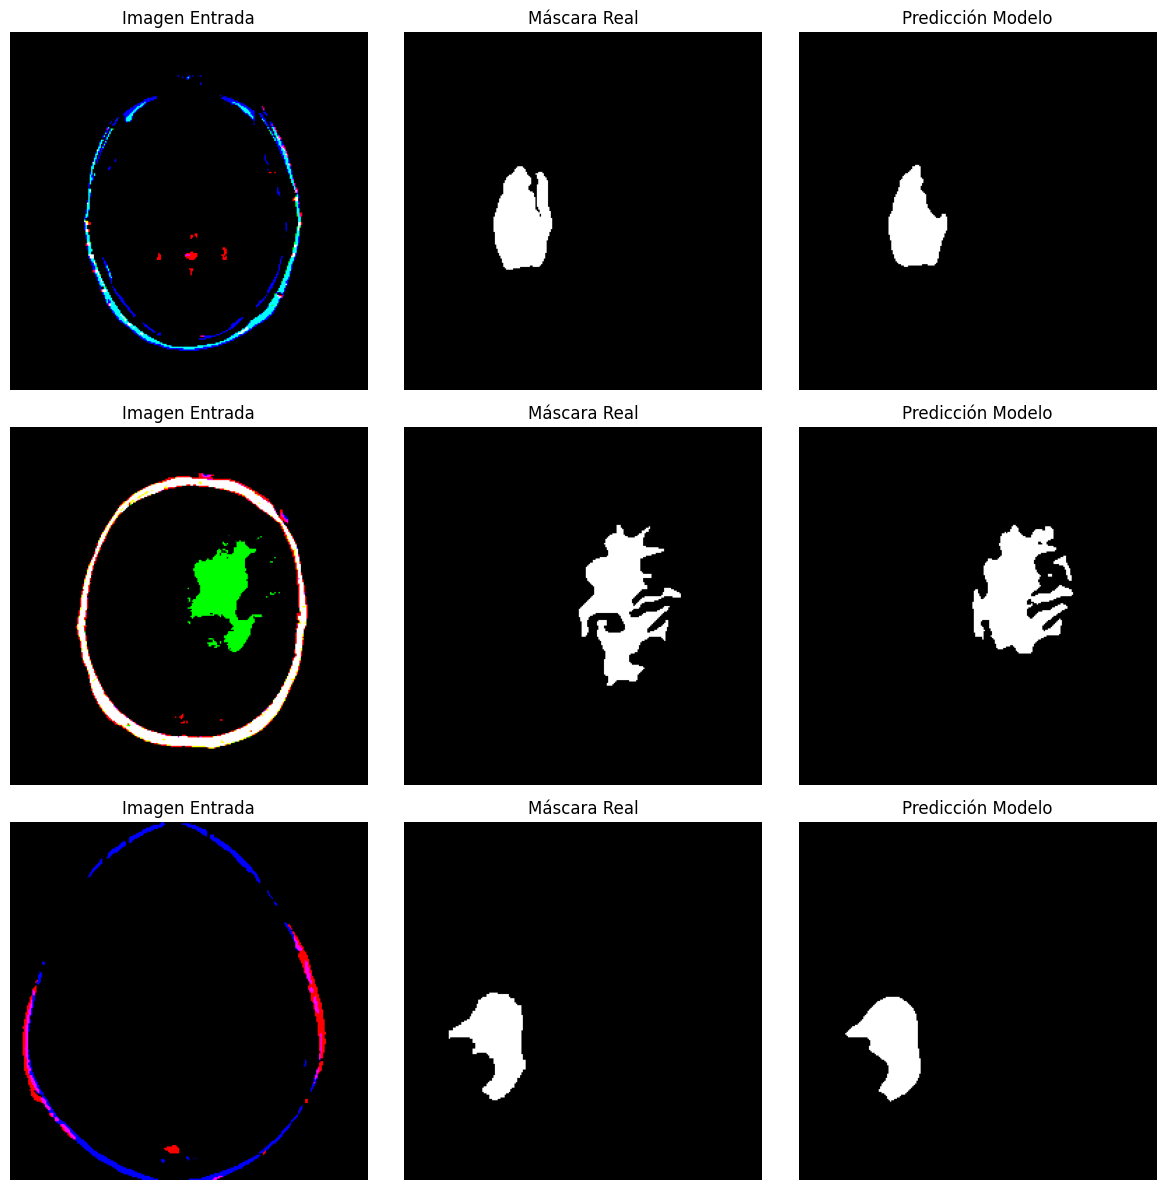

In [32]:
model.load_weights('mejor_modelo_segmentacion.keras')

# Predecir sobre datos de validación
preds_val = model.predict(X_val, verbose=1)
# Binarizar la predicción (si es > 0.5 es tumor)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

def plot_resultados(X, Y, Preds, n_samples=3):
    indices = np.random.choice(len(X), n_samples, replace=False)

    plt.figure(figsize=(12, 4 * n_samples))

    for i, idx in enumerate(indices):
        # Imagen Original
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(X[idx]) # Nota: Al usar preprocess_input los colores pueden verse raros, es normal
        plt.title('Imagen Entrada')
        plt.axis('off')

        # Máscara Real
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(Y[idx].squeeze(), cmap='gray')
        plt.title('Máscara Real')
        plt.axis('off')

        # Predicción del Modelo
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(Preds[idx].squeeze(), cmap='gray') # Mostramos la predicción
        plt.title('Predicción Modelo')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Resultados en validación:")
plot_resultados(X_val, Y_val, preds_val_t)

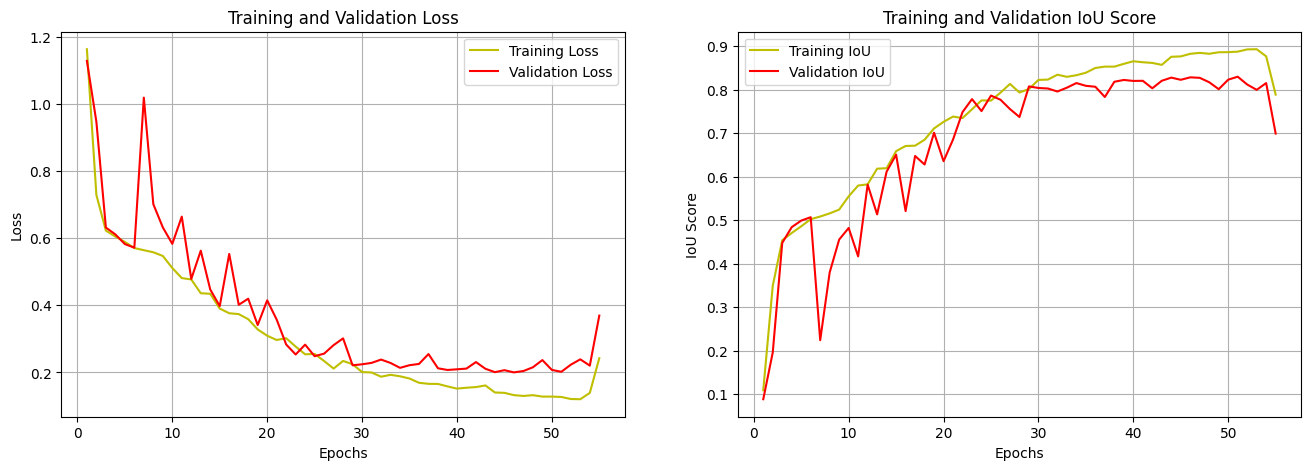

In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extraer valores
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history['iou_score']
    val_iou = history.history['val_iou_score']
    epochs = range(1, len(loss) + 1)

    # Crear gráficos
    plt.figure(figsize=(16, 5))

    # Gráfico de PÉRDIDA (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Gráfico de MÉTRICA (IoU - Intersection over Union)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, iou, 'y', label='Training IoU')
    plt.plot(epochs, val_iou, 'r', label='Validation IoU')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.grid(True)

    plt.show()

# EJECUTAR LA VISUALIZACIÓN
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


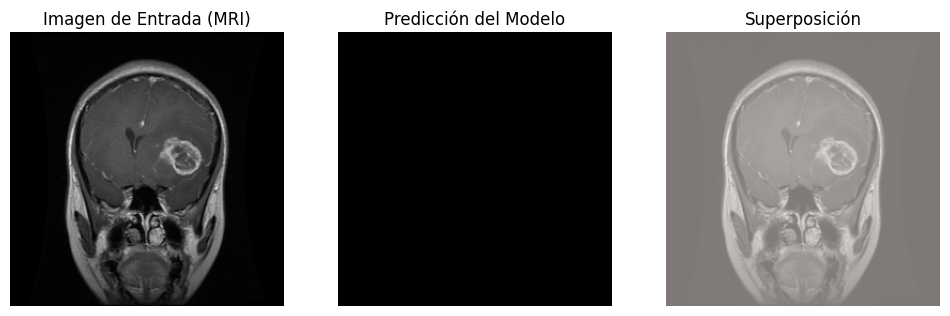

Probabilidad máxima detectada: 0.0106


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm

# Ruta de tu imagen
ruta_imagen = '/content/glioma (113).jpg'

# 1. Leer la imagen
img_original = cv2.imread(ruta_imagen)

if img_original is None:
    print("❌ Error: No se encuentra la imagen.")
else:
    # ---------------------------------------------------------
    # CAMINO 1: PREPARAR PARA EL OJO HUMANO (VISUALIZACIÓN)
    # ---------------------------------------------------------
    # Pasamos a RGB
    img_visual = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    # Redimensionamos a 256x256
    img_visual = cv2.resize(img_visual, (256, 256))

    # ---------------------------------------------------------
    # CAMINO 2: PREPARAR PARA EL MODELO (PREDICCIÓN)
    # ---------------------------------------------------------
    # Hacemos una copia para no estropear la imagen visual
    img_input = img_visual.copy()

    # Expandimos dimensiones a (1, 256, 256, 3)
    x = np.expand_dims(img_input, axis=0)

    # ¡CLAVE! Aplicamos el preprocesamiento UNA SOLA VEZ y solo a 'x'
    # Asegúrate de que esto coincide con tu modelo (VGG16)
    preprocess_input = sm.get_preprocessing('vgg16')
    x = preprocess_input(x)

    # 3. Predicción
    prediccion_raw = model.predict(x)

    # 4. Binarizar
    # Ajusta este 0.5 si ves mucho o poco ruido
    prediccion_mask = (prediccion_raw > 0.5).astype(np.uint8)[0, :, :, 0]

    # 5. Visualización
    plt.figure(figsize=(12, 6))

    # A) Imagen Original (Usamos img_visual, la LIMPIA)
    plt.subplot(1, 3, 1)
    plt.imshow(img_visual)
    plt.title("Imagen de Entrada (MRI)")
    plt.axis('off')

    # B) Predicción
    plt.subplot(1, 3, 2)
    plt.imshow(prediccion_mask, cmap='gray')
    plt.title("Predicción del Modelo")
    plt.axis('off')

    # C) Superposición
    plt.subplot(1, 3, 3)
    plt.imshow(img_visual) # Pintamos la limpia debajo
    plt.imshow(prediccion_mask, cmap='Blues', alpha=0.5) # Pintamos la máscara encima
    plt.title("Superposición")
    plt.axis('off')

    plt.show()

    print(f"Probabilidad máxima detectada: {np.max(prediccion_raw):.4f}")

## ResNet 34

In [35]:
IMG_SIZE = 256

def cargar_datos_para_modelo(df, img_size):
    X = []
    Y = []

    print(f"⚙️ Procesando {len(df)} imágenes para el entrenamiento...")

    for _, row in df.iterrows():
        # -- Imagen (Input) --
        img = cv2.imread(row['image_path'])
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Importante: RGB
        #img = img / 255.0  # Normalizar [0,1]
        X.append(img)

        # -- Máscara (Output) --
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.0 # Normalizar [0,1]

        # Binarizar para asegurar que sea 0 o 1 (Tumor o Fondo)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)

    # Expandir dimensiones de la máscara para que sea (N, 256, 256, 1)
    Y = np.expand_dims(Y, axis=-1)

    return X, Y

# Ejecutamos la carga usando tu dataframe 'df_segmentacion'
X, Y = cargar_datos_para_modelo(df_segmentacion, IMG_SIZE)

print(f"✅ Datos listos. X shape: {X.shape}, Y shape: {Y.shape}")

# Dividimos en Train y Validación (80% - 20%)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

⚙️ Procesando 1373 imágenes para el entrenamiento...
✅ Datos listos. X shape: (1373, 256, 256, 3), Y shape: (1373, 256, 256, 1)


In [36]:
import segmentation_models as sm
import tensorflow as tf

# 1. CAMBIO CLAVE: Definimos el nuevo backbone
BACKBONE = 'resnet34'

# 2. IMPORTANTE: Cargar el preprocesador específico de ResNet34
# ResNet preprocesa distinto que VGG16, si no cambias esto, fallará.
preprocess_input = sm.get_preprocessing(BACKBONE)

# Asumiendo que 'X_train' y 'X_val' son tus imágenes originales (0-255) sin dividir
# Aplicamos el preprocesamiento de ResNet
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# 3. Definir el modelo U-Net con ResNet34
model = sm.Unet(BACKBONE,
                       encoder_weights='imagenet',
                       encoder_freeze=False, # Dejamos que aprenda (Fine-tuning)
                       classes=1,
                       activation='sigmoid')

# 4. Compilar (Usamos las mismas métricas que antes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)

print("🚀 Modelo ResNet34-UNet listo para entrenar.")

🚀 Modelo ResNet34-UNet listo para entrenar.


In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mejor_modelo_segmentacion.keras', save_best_only=True, mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, verbose=1)
]

print("🏋️‍♂️ Iniciando entrenamiento...")

history = model.fit(
    X_train,
    Y_train,
    batch_size=16, # Si te da error de memoria, baja a 8
    epochs=60,
    validation_split=0.2,
    callbacks=callbacks
)

🏋️‍♂️ Iniciando entrenamiento...
Epoch 1/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 444ms/step - iou_score: 0.0364 - loss: 1.2961 - val_iou_score: 0.0231 - val_loss: 1.3692
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - iou_score: 0.1039 - loss: 1.0602 - val_iou_score: 0.0918 - val_loss: 1.1066
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - iou_score: 0.1984 - loss: 0.8979 - val_iou_score: 0.1703 - val_loss: 0.9539
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - iou_score: 0.3306 - loss: 0.7345 - val_iou_score: 0.2705 - val_loss: 0.8101
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - iou_score: 0.4403 - loss: 0.6057 - val_iou_score: 0.4030 - val_loss: 0.6489
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - iou_score: 0.5217 - loss: 0.5147 - val_iou_score: 0.5152 - val_loss: 0.5229
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - iou_score: 0.6211 - loss: 0.4067 - val_iou_score: 0.5613 - val_loss: 0.4740
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - iou_score

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step
Resultados en validación:


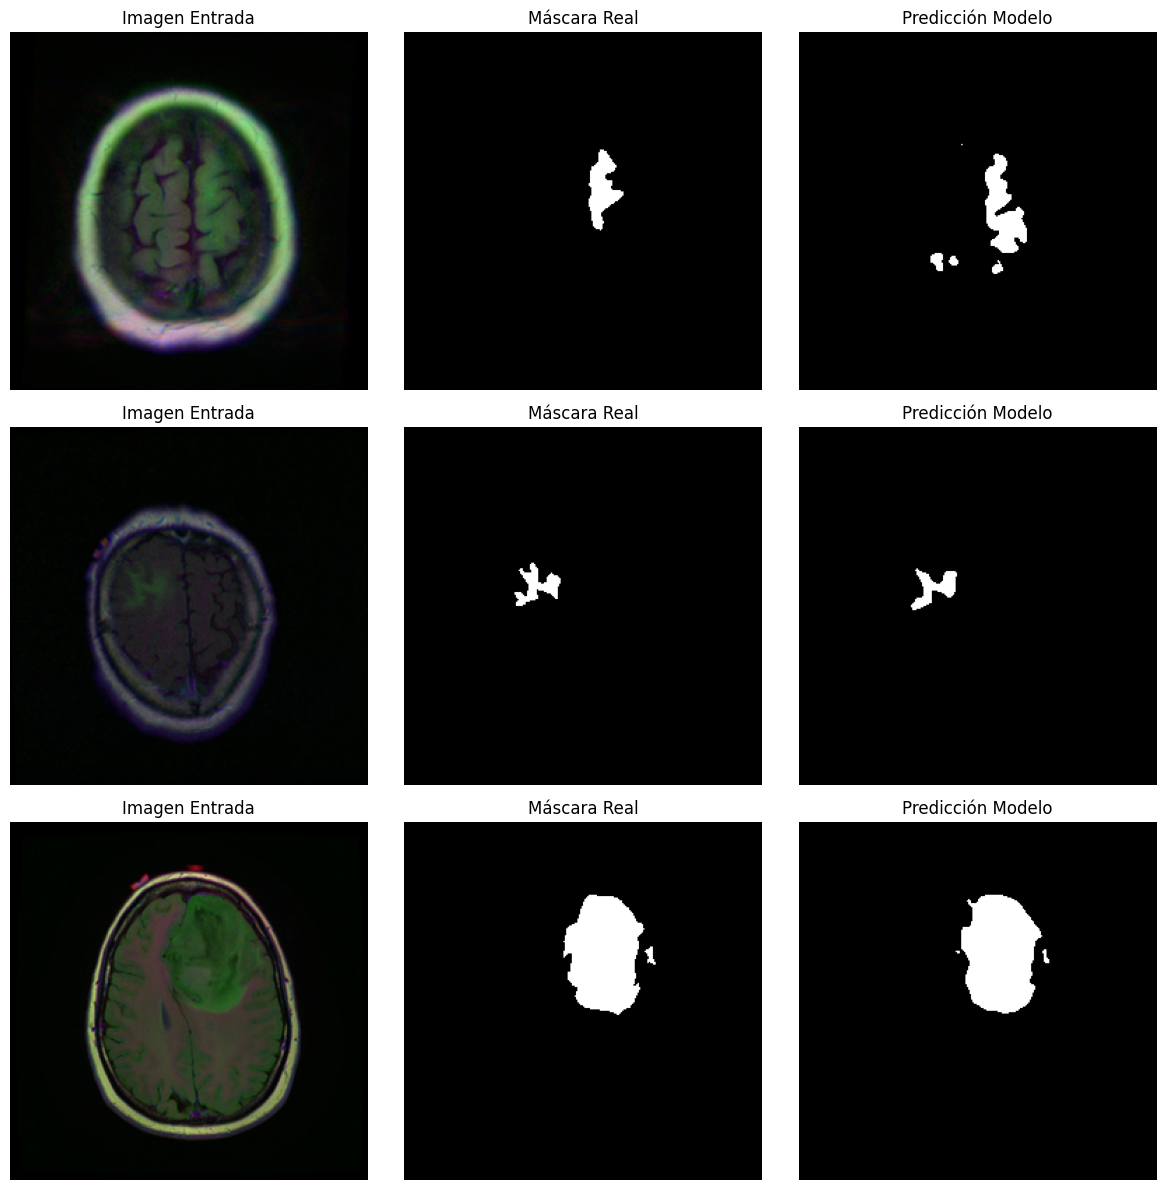

In [38]:
model.load_weights('mejor_modelo_segmentacion.keras')

# Predecir sobre datos de validación
preds_val = model.predict(X_val, verbose=1)
# Binarizar la predicción (si es > 0.5 es tumor)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

def plot_resultados(X, Y, Preds, n_samples=3):
    indices = np.random.choice(len(X), n_samples, replace=False)

    plt.figure(figsize=(12, 4 * n_samples))

    for i, idx in enumerate(indices):
        # Imagen Original
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(X[idx]) # Nota: Al usar preprocess_input los colores pueden verse raros, es normal
        plt.title('Imagen Entrada')
        plt.axis('off')

        # Máscara Real
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(Y[idx].squeeze(), cmap='gray')
        plt.title('Máscara Real')
        plt.axis('off')

        # Predicción del Modelo
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(Preds[idx].squeeze(), cmap='gray') # Mostramos la predicción
        plt.title('Predicción Modelo')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Resultados en validación:")
plot_resultados(X_val, Y_val, preds_val_t)

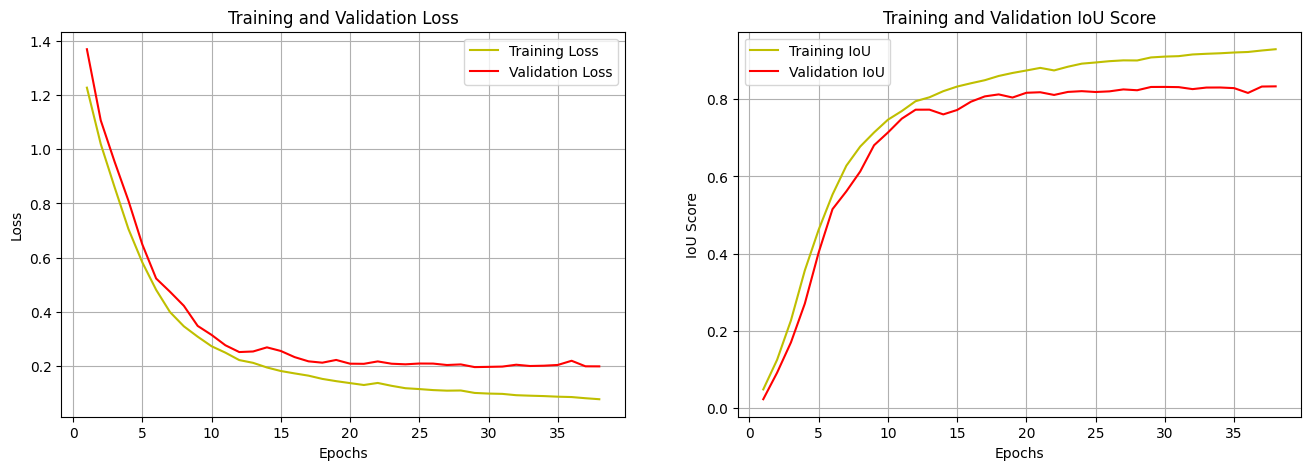

In [39]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extraer valores
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history['iou_score']
    val_iou = history.history['val_iou_score']
    epochs = range(1, len(loss) + 1)

    # Crear gráficos
    plt.figure(figsize=(16, 5))

    # Gráfico de PÉRDIDA (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Gráfico de MÉTRICA (IoU - Intersection over Union)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, iou, 'y', label='Training IoU')
    plt.plot(epochs, val_iou, 'r', label='Validation IoU')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.grid(True)

    plt.show()

# EJECUTAR LA VISUALIZACIÓN
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


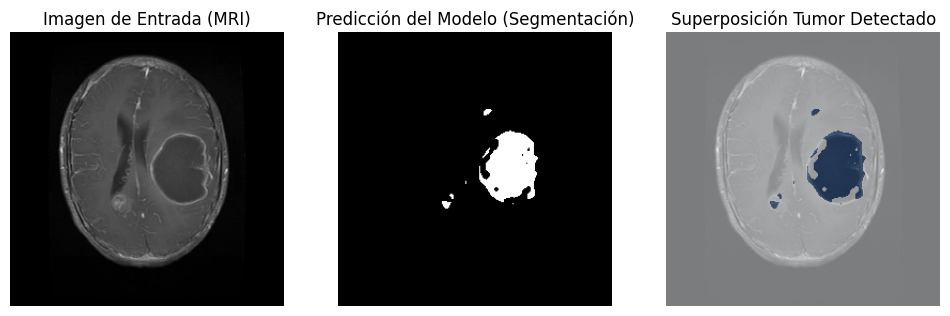

Probabilidad máxima detectada en la imagen: 1.0000


In [52]:
ruta_imagen = '/content/glioma (137).jpg'

# Leer la imagen
img_original = cv2.imread(ruta_imagen)

if img_original is None:
    print("❌ Error: No se encuentra la imagen. Asegúrate de subirla a Colab.")
else:
    # 2. Preprocesamiento (IGUAL que en el entrenamiento)
    # A) Pasamos a RGB
    img = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # B) Redimensionamos a 256x256 (el tamaño que espera el modelo)
    img = cv2.resize(img, (256, 256))

    # C) ¡CLAVE! Usamos el preprocesador de VGG16 (hace la resta de la media, etc.)
    # NO dividimos por 255 manualmente, dejamos que esto lo haga si es necesario
    #preprocess_input = sm.get_preprocessing('vgg16')
    preprocess_input = sm.get_preprocessing(BACKBONE)
    img = preprocess_input(img)

    # Expandimos dimensiones porque el modelo espera un lote de imágenes (1, 256, 256, 3)
    x = np.expand_dims(img, axis=0)

    # Aplicamos el preprocesamiento a los datos crudos
    x = preprocess_input(x)

    # 3. Predicción
    # El modelo devuelve probabilidades entre 0 y 1 para cada píxel
    prediccion_raw = model.predict(x)

    # 4. Binarizar (Thresholding)
    # Todo lo que tenga más de 50% de probabilidad es tumor (1), el resto es fondo (0)
    prediccion_mask = (prediccion_raw > 0.99).astype(np.uint8)[0, :, :, 0]

    # 5. Visualización Profesional para el TFG
    plt.figure(figsize=(12, 6))

    # Imagen Original (Redimensionada)
    plt.subplot(1, 3, 1)
    plt.imshow(img) # Mostramos la imagen limpia (sin el preprocesamiento extraño de VGG)
    plt.title("Imagen de Entrada (MRI)")
    plt.axis('off')

    # Lo que predice el modelo (Máscara)
    plt.subplot(1, 3, 2)
    plt.imshow(prediccion_mask, cmap='gray')
    plt.title("Predicción del Modelo (Segmentación)")
    plt.axis('off')

    # Superposición (Overlay) para que quede bonito
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    # Creamos una máscara roja transparente
    plt.imshow(prediccion_mask, cmap='Blues', alpha=0.5)
    plt.title("Superposición Tumor Detectado")
    plt.axis('off')

    plt.show()

    print(f"Probabilidad máxima detectada en la imagen: {np.max(prediccion_raw):.4f}")

In [42]:
model.save_weights('pesos_unet_resnet34_fabulosos.weights.h5')

print("✅ Pesos guardados en Colab.")

✅ Pesos guardados en Colab.


## Modelo Simple

In [23]:
IMG_SIZE = 256

def cargar_datos_para_modelo(df, img_size):
    X = []
    Y = []

    print(f"⚙️ Procesando {len(df)} imágenes para el entrenamiento...")

    for _, row in df.iterrows():
        # -- Imagen (Input) --
        img = cv2.imread(row['image_path'])
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Importante: RGB
        #img = img / 255.0  # Normalizar [0,1]
        X.append(img)

        # -- Máscara (Output) --
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask = mask / 255.0 # Normalizar [0,1]

        # Binarizar para asegurar que sea 0 o 1 (Tumor o Fondo)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)

    # Expandir dimensiones de la máscara para que sea (N, 256, 256, 1)
    Y = np.expand_dims(Y, axis=-1)

    return X, Y

# Ejecutamos la carga usando tu dataframe 'df_segmentacion'
X, Y = cargar_datos_para_modelo(df_segmentacion, IMG_SIZE)

print(f"✅ Datos listos. X shape: {X.shape}, Y shape: {Y.shape}")

# Dividimos en Train y Validación (80% - 20%)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

⚙️ Procesando 1373 imágenes para el entrenamiento...
✅ Datos listos. X shape: (1373, 256, 256, 3), Y shape: (1373, 256, 256, 1)


In [24]:
def crear_mi_unet_propia(input_shape=(256, 256, 3)):
    # Entrada de la red
    inputs = layers.Input(input_shape)

    # ==========================================
    # 1. ENCODER (Bajada / Contracción)
    # Su misión: Extraer el "QUÉ" hay en la imagen (patrones)
    # ==========================================

    # Bloque 1
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1) # Reduce tamaño a la mitad (128x128)

    # Bloque 2
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2) # Reduce tamaño a la mitad (64x64)

    # Bloque 3
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3) # Reduce tamaño a la mitad (32x32)

    # ==========================================
    # 2. CUELLO DE BOTELLA (Bridge)
    # La parte más profunda de la red
    # ==========================================
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # ==========================================
    # 3. DECODER (Subida / Expansión)
    # Su misión: Recuperar el "DÓNDE" estaba el tumor (tamaño original)
    # ==========================================

    # Bloque de Subida 1
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    # ¡Truco maestro! Concatenamos con c3 para no perder detalles finos (Skip Connection)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    # Bloque de Subida 2
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2]) # Concatenamos con c2
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    # Bloque de Subida 3
    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1]) # Concatenamos con c1
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # ==========================================
    # 4. SALIDA
    # ==========================================
    # Usamos Sigmoid porque queremos probabilidad de tumor (0 a 1) por píxel
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="Mi_UNet_Basica")
    return model

# Crear el modelo
model_propio = crear_mi_unet_propia()

# Mostrar resumen para que veas lo que has creado
model_propio.summary()

Model: "Mi_UNet_Basica"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Definimos una métrica de Dice simple (la que les gusta a los médicos)
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Compilamos TU modelo
model_propio.compile(optimizer='adam',
                     loss=dice_loss,  # Usamos Dice Loss porque funciona mejor para tumores
                     metrics=['accuracy', dice_coef])

# Entrenamos (¡Asegúrate de tener X_train y Y_train preparados como antes!)
history_propio = model_propio.fit(
    X_train, Y_train,
    batch_size=16,
    epochs=30, # Al ser desde 0, quizás necesite un poco más que el preentrenado
    validation_data=(X_val, Y_val)
)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.8457 - dice_coef: 0.0163 - loss: 0.9837 - val_accuracy: 0.9703 - val_dice_coef: 3.8168e-05 - val_loss: 1.0000
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9718 - dice_coef: 3.5284e-05 - loss: 1.0000 - val_accuracy: 0.9703 - val_dice_coef: 3.8168e-05 - val_loss: 1.0000
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9703 - dice_coef: 3.3334e-05 - loss: 1.0000 - val_accuracy: 0.9703 - val_dice_coef: 3.8168e-05 - val_loss: 1.0000
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9701 - dice_coef: 3.3228e-05 - loss: 1.0000 - val_accuracy: 0.9703 - val_dice_coef: 3.8168e-05 - val_loss: 1.0000
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9712 - dice_coef: 3.4554e-05 - loss: 1.0000 - val_accuracy: 0.9703 - val_dice_coef: 3.8168e-05 - val_loss: 1.0000
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9707 - dice_coef: 3.3758e-05 - loss: 1.000

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step
Resultados en validación:


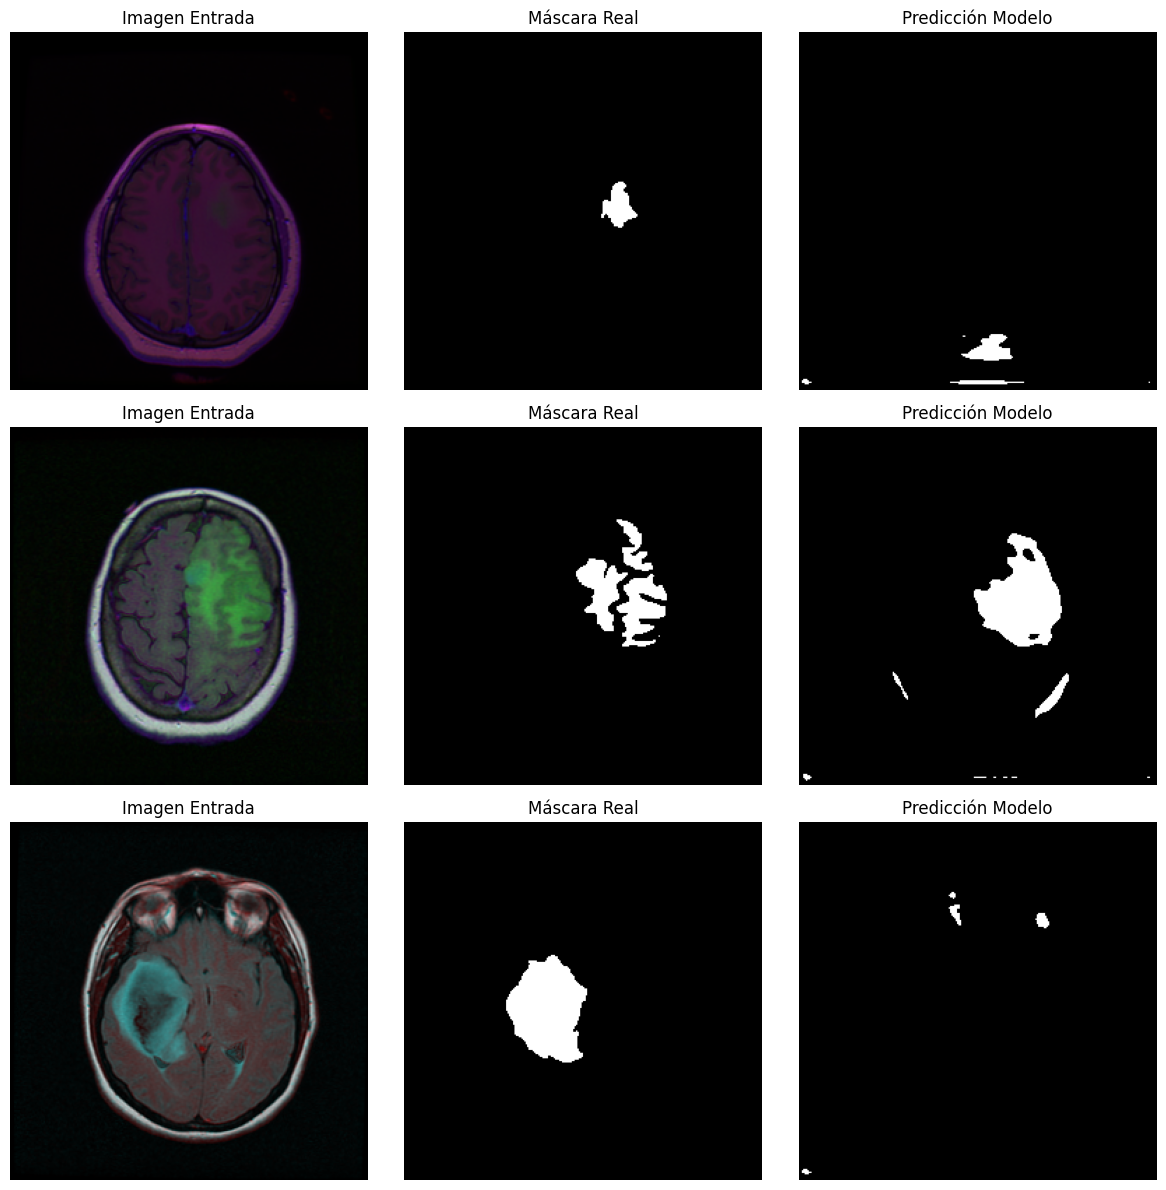

In [26]:
model.load_weights('mejor_modelo_segmentacion.keras')

# Predecir sobre datos de validación
preds_val = model.predict(X_val, verbose=1)
# Binarizar la predicción (si es > 0.5 es tumor)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

def plot_resultados(X, Y, Preds, n_samples=3):
    indices = np.random.choice(len(X), n_samples, replace=False)

    plt.figure(figsize=(12, 4 * n_samples))

    for i, idx in enumerate(indices):
        # Imagen Original
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(X[idx]) # Nota: Al usar preprocess_input los colores pueden verse raros, es normal
        plt.title('Imagen Entrada')
        plt.axis('off')

        # Máscara Real
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(Y[idx].squeeze(), cmap='gray')
        plt.title('Máscara Real')
        plt.axis('off')

        # Predicción del Modelo
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(Preds[idx].squeeze(), cmap='gray') # Mostramos la predicción
        plt.title('Predicción Modelo')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Resultados en validación:")
plot_resultados(X_val, Y_val, preds_val_t)

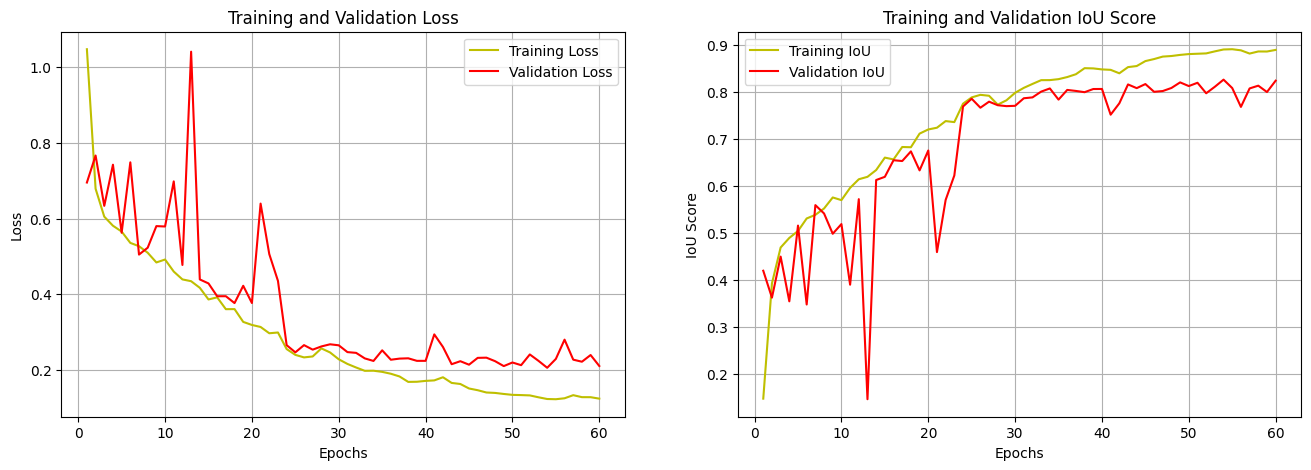

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extraer valores
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history['iou_score']
    val_iou = history.history['val_iou_score']
    epochs = range(1, len(loss) + 1)

    # Crear gráficos
    plt.figure(figsize=(16, 5))

    # Gráfico de PÉRDIDA (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'y', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Gráfico de MÉTRICA (IoU - Intersection over Union)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, iou, 'y', label='Training IoU')
    plt.plot(epochs, val_iou, 'r', label='Validation IoU')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.grid(True)

    plt.show()

# EJECUTAR LA VISUALIZACIÓN
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


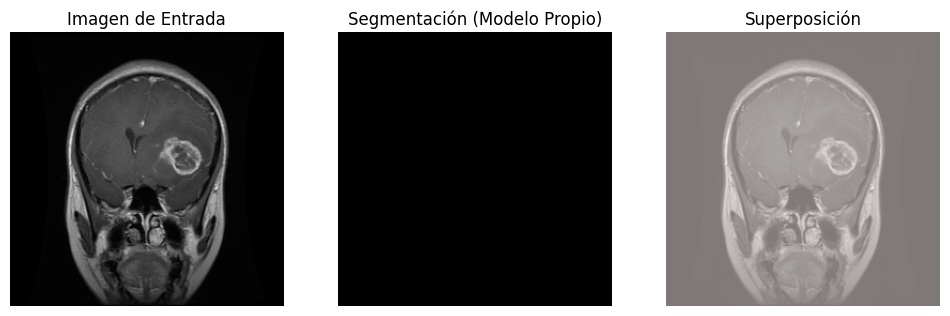

Probabilidad máxima detectada: 0.0000


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

ruta_imagen = '/content/glioma (113).jpg' # Asegúrate que la ruta es correcta

# 1. Leer la imagen
img_original = cv2.imread(ruta_imagen)

if img_original is None:
    print("❌ Error: No se encuentra la imagen. Asegúrate de subirla a Colab.")
else:
    # 2. Preprocesamiento (ADAPTADO AL MODELO PROPIO)
    # A) Pasamos a RGB
    img = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # B) Redimensionamos a 256x256
    img = cv2.resize(img, (256, 256))

    # C) ¡CAMBIO CLAVE! Normalización manual simple
    # El modelo propio se entrenó con img / 255.0, así que aquí hacemos lo mismo.
    # NO usamos sm.get_preprocessing aquí.
    img_input = img.astype('float32') / 255.0

    # Expandimos dimensiones (1, 256, 256, 3)
    x = np.expand_dims(img_input, axis=0)

    # 3. Predicción
    # Asegúrate de usar la variable de tu modelo propio (ej: model_propio)
    prediccion_raw = model_propio.predict(x)

    # 4. Binarizar (Thresholding)
    # Probamos con 0.5, pero puedes subir a 0.7 si ves mucho ruido
    prediccion_mask = (prediccion_raw > 0.5).astype(np.uint8)[0, :, :, 0]

    # 5. Visualización
    plt.figure(figsize=(12, 6))

    # Imagen Original (Usamos 'img' que tiene los colores bien)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Imagen de Entrada")
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 2)
    plt.imshow(prediccion_mask, cmap='gray')
    plt.title("Segmentación (Modelo Propio)")
    plt.axis('off')

    # Superposición
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(prediccion_mask, cmap='Blues', alpha=0.5)
    plt.title("Superposición")
    plt.axis('off')

    plt.show()

    print(f"Probabilidad máxima detectada: {np.max(prediccion_raw):.4f}")